## Importing the libraries

In [1]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
from skimage import color
!pip install mahotas
import mahotas as mt
from skimage.color import rgb2gray
import warnings
warnings.filterwarnings("ignore")


     |████████████████████████████████| 1.5MB 2.8MB/s 
  Created wheel for mahotas: filename=mahotas-1.4.9-cp36-cp36m-linux_x86_64.whl size=4363423 sha256=57207f2c58e8bf8c53616a45ab2b9d6b6ba66a98d7db6b4a6c05ecfcb4af54ac
  Stored in directory: /root/.cache/pip/wheels/02/e7/50/b67eee3b19c479cc5b41f10230bf9c1556be6eaaf095c6e997
Successfully built mahotas


In [2]:


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/extracted-feature/train_feature_deepstat_6.csv
/kaggle/input/extracted-feature/test_feature_deepsat_6.csv
/kaggle/input/deepsat-sat6/X_train_sat6.csv
/kaggle/input/deepsat-sat6/y_test_sat6.csv
/kaggle/input/deepsat-sat6/sat-6-full.mat
/kaggle/input/deepsat-sat6/X_test_sat6.csv
/kaggle/input/deepsat-sat6/y_train_sat6.csv
/kaggle/input/deepsat-sat6/sat6annotations.csv


## Data Reading

In [3]:
train_data_path="/kaggle/input/deepsat-sat6/X_train_sat6.csv"
train_label_path="/kaggle/input/deepsat-sat6/y_train_sat6.csv"
test_data_path="/kaggle/input/deepsat-sat6/X_test_sat6.csv"
test_lable_path="/kaggle/input/deepsat-sat6/y_test_sat6.csv"

In [4]:
def data_read(data_path, nrows):
    data=pd.read_csv(data_path, header=None, nrows=nrows)
    data=data.values ## converting the data into numpy array
    return data

In [5]:
##Read training data
train_data=data_read(train_data_path, nrows=500)
print("Train data shape:" + str(train_data.shape))

##Read training data labels
train_data_label=data_read(train_label_path,nrows=500)
print("Train data label shape:" + str(train_data_label.shape))
print()

##Read test data
test_data=data_read(test_data_path, nrows=100)
print("Test data shape:" + str(test_data.shape))


##Read test data labels
test_data_label=data_read(test_lable_path,nrows=100)
print("Test data label shape:" + str(test_data_label.shape))


Train data shape:(500, 3136)
Train data label shape:(500, 6)

Test data shape:(100, 3136)
Test data label shape:(100, 6)


## Data Visualization

In [6]:
#label converter
# [1,0,0,0,0,0]=building
# [0,1,0,0,0,0]=barren_land
# [0,0,1,0,0,0]=trees
# [0,0,0,1,0,0]=grassland
# [0,0,0,0,1,0]=road
# [0,0,0,0,0,1]=water


def label_conv(label_arr):
    labels=[]
    for i in range(len(label_arr)):
        
        if (label_arr[i]==[1,0,0,0,0,0]).all():
            labels.append("Building")  
            
        elif (label_arr[i]==[0,1,0,0,0,0]).all():  
            labels.append("Barren_land")  
            
        elif (label_arr[i]==[0,0,1,0,0,0]).all():
            labels.append("Tree") 
            
        elif (label_arr[i]==[0,0,0,1,0,0]).all():
            labels.append("Grassland")
            
        elif (label_arr[i]==[0,0,0,0,1,0]).all():
            labels.append("Road") 
            
        else:
            labels.append("Water")
    return labels
train_label_convert=label_conv(train_data_label)##train label conveter
test_label_convert=label_conv(test_data_label) ##test label converter


def data_visualization(data, label, n):
    ##data: training or test data
    ##lable: training or test labels
    ## n: number of data point, it should be less than or equal to no. of data points
    fig = plt.figure(figsize=(14, 14))
    ax = []  # ax enables access to manipulate each of subplots
    rows, columns=4,4
    for i in range(columns*rows):
        index=np.random.randint(1,n)
        img= data[index].reshape([28,28,4])[:,:,:3] ##reshape input data to rgb image
        ax.append( fig.add_subplot(rows, columns, i+1) ) # create subplot and append to ax
        ax[-1].set_title("Class:"+str(label[index]))  # set class
        plt.axis("off")
        plt.imshow(img)

    plt.subplots_adjust(wspace=0.1,hspace=0.5)
    plt.show()  # finally, render the plot

## Training data visualization

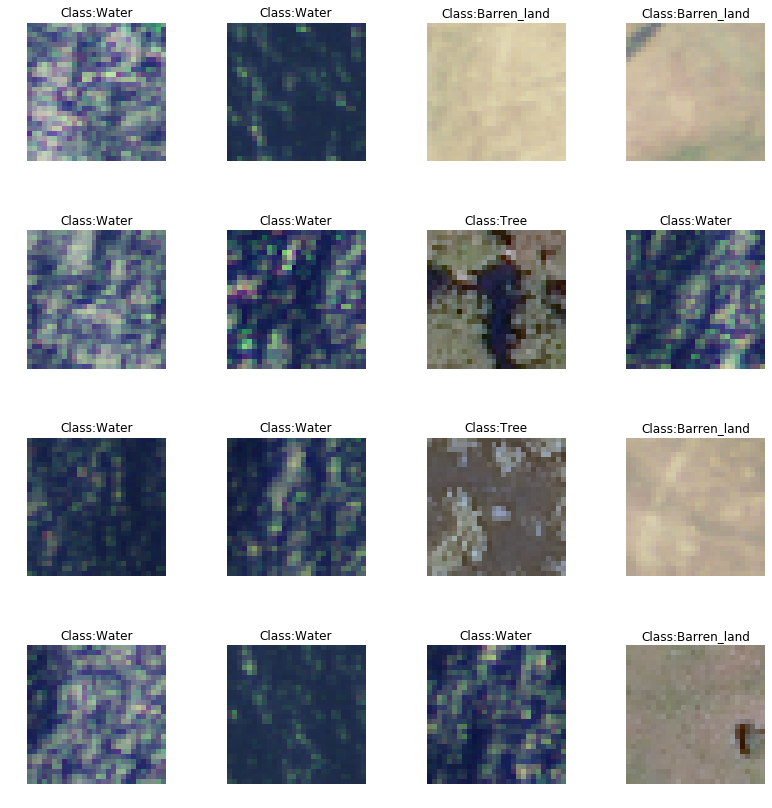

In [7]:
data_visualization(train_data,train_label_convert, n=500)

## Test data visualization

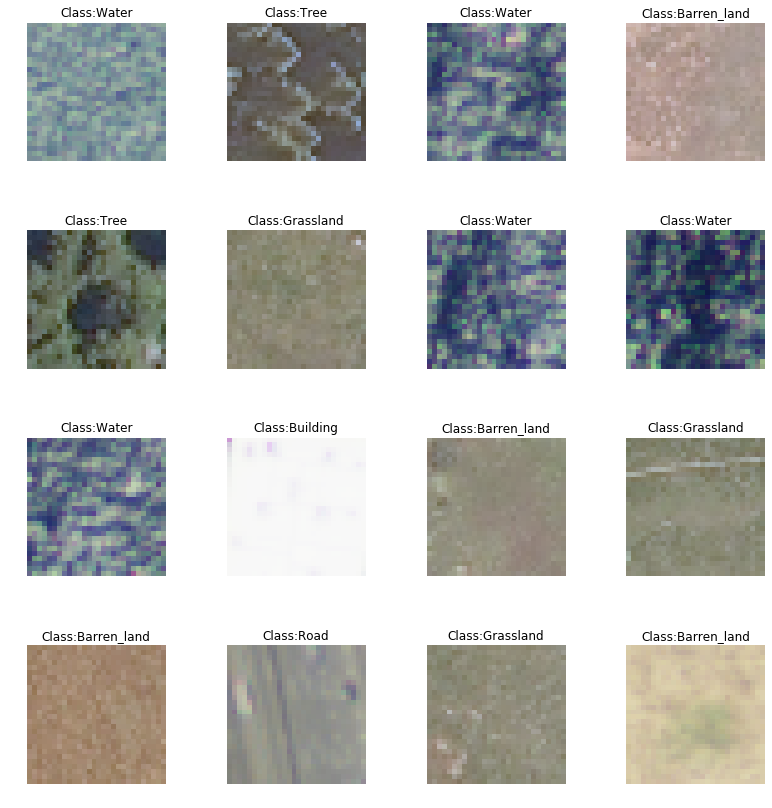

In [8]:
data_visualization(test_data,test_label_convert, n=100)

## Features Extraction¶

In [9]:

#  texture_features=["Angular Second Moment","Contrast","Correlation","Sum of Squares: Variance","Inverse Difference Moment",
#                    "Sum Average","Sum Variance","Sum Entropy","Entropy","Difference Variance","Difference Entropy",
#                    "Information Measure of Correlation 1","Information Measure of Correlation 2""Maximal Correlation Coefficient"]

#https://gogul09.github.io/software/texture-recognition #references for texture feature calculations

def feature_extractor(input_image_file):
    
        tex_feature=[]
        hsv_feature=[]
        ndvi_feature=[]
        arvi_feature=[]

        for df_chunk in pd.read_csv(input_image_file ,header=None,chunksize = 5000):

            df_chunk=df_chunk.astype("int32")
            data=df_chunk.values


            ################data for HSV and Texture feature##############
            img=data.reshape(-1,28,28,4)[:,:,:,:3]
            #############################################################

            ######################Data for NDVI and ARVI#################

            NIR=data.reshape(-1,28,28,4)[:,:,:,3]
            Red=data.reshape(-1,28,28,4)[:,:,:,2]
            Blue=data.reshape(-1,28,28,4)[:,:,:,0]
            #############################################################

            for i in range(len(data)):

                #######Texture_feature####################################
                textures = mt.features.haralick(img[i])
                ht_mean= textures.mean(axis=0)
                tex_feature.append(ht_mean)
                ##########################################################

                #######hsv_feature#########################################
                img_hsv = color.rgb2hsv(img[i]) # Image into HSV colorspace
                h = img_hsv[:,:,0] # Hue
                s = img_hsv[:,:,1] # Saturation
                v = img_hsv[:,:,2] # Value aka Lightness
                hsv_feature.append((h.mean(),s.mean(),v.mean()))
                ###########################################################

                ##########Calculation of NDVI Feature######################
                NDVI=(NIR[i]-Red[i])/(NIR[i]+Red[i])
                ndvi_feature.append(NDVI.mean())
                ############################################################

                ###################Calculation of ARVI#####################
                a_1=NIR[i] -(2*Red[i]-Blue[i])
                a_2=NIR[i] +(2*Red[i]+Blue[i])
                arvi=a_1/a_2
                arvi_feature.append(arvi.mean())
                #######################################################

        features=[]
        for i in range(len(tex_feature)):
            h_stack=np.hstack((tex_feature[i], hsv_feature[i], ndvi_feature[i], arvi_feature[i]))
            features.append(h_stack)
            
        return features

## Features extraction from training data

In [10]:
train_data_features=feature_extractor(train_data_path)
# saving train data features
feature=pd.DataFrame(train_data_features, columns=["feature"+ str(i) for i in range(len(train_data_features[0]))])
feature.to_csv("train_feature_deepstat_6.csv")

## Features extraction from test data

In [11]:
#test data features extraction
test_data_features=feature_extractor(test_data_path)
feature_test=pd.DataFrame(test_data_features, columns=["feature"+ str(i) for i in range(len(train_data_features[0]))])
feature_test.to_csv("test_feature_deepsat_6.csv")

## Model Building

In [12]:
from sklearn.preprocessing import StandardScaler 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from time import time
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [13]:
def data_read_(data_path):
    df=pd.read_csv(data_path, index_col=[0])
    return df

def label_read(data_path):
    df=pd.read_csv(data_path, header=None)
    return df


## Reading training data feature and training data label

In [14]:

train_feature_deepstat_6=data_read_(data_path="/kaggle/input/extracted-feature/train_feature_deepstat_6.csv")
train_label=label_read(data_path=train_label_path)
print("Training data shape: ",train_feature_deepstat_6.shape)
print("Training label shape: ",train_label.shape)

Training data shape:  (324000, 18)
Training label shape:  (324000, 6)


In [15]:
train_feature_deepstat_6.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17
0,0.000510,617.467448,0.744604,1208.225664,0.075734,165.287322,4215.435207,7.637573,11.158415,0.000144,5.546250,-0.356272,0.995773,0.365449,0.207631,4.211562e-08,0.130287,0.082918
1,0.001207,417.651225,0.397474,373.466474,0.082166,321.815240,1076.214670,6.722432,10.047084,0.000350,4.048463,-0.345718,0.991588,0.090416,0.258090,8.581116e-08,0.136626,0.142940
2,0.000398,1943.661871,0.403912,1619.892120,0.041302,156.599515,4535.906611,7.854340,11.419267,0.000051,6.343184,-0.394795,0.998089,0.599307,0.510874,5.071253e-08,-0.762366,-0.488413
3,0.000410,1016.512108,0.571321,1181.209671,0.048341,160.536238,3708.326575,7.776289,11.377842,0.000085,5.898673,-0.375375,0.997312,0.579702,0.435979,4.884989e-08,-0.779538,-0.482682
4,0.000647,487.816884,0.296176,345.964345,0.067422,288.690819,896.040495,6.823493,10.881089,0.000118,5.422547,-0.235495,0.972060,0.516917,0.193726,7.365289e-08,-0.659481,-0.320696


In [16]:
train_label.head()

,0,1,2,3,4,5
0,0,0,1,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


## Reading test data feature and test data label

In [17]:
test_feature_deepsat_6=data_read_(data_path="/kaggle/input/extracted-feature/test_feature_deepsat_6.csv")
test_label=label_read(data_path=test_lable_path)
print("Training data shape: ",test_feature_deepsat_6.shape)
print("Training label shape: ",test_label.shape)

Training data shape:  (81000, 18)
Training label shape:  (81000, 6)


In [18]:
test_feature_deepsat_6.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17
0,0.000472,825.146019,0.483915,799.436334,0.054771,163.380355,2372.599315,7.433824,11.232332,0.000107,5.772372,-0.321464,0.992508,0.342550,0.203484,4.158225e-08,0.300045,0.188149
1,0.000747,450.118996,0.520765,468.906282,0.082015,203.764809,1425.506132,7.055624,10.791574,0.000153,5.301941,-0.278724,0.983755,0.203896,0.131008,5.035616e-08,0.235854,0.156365
2,0.000375,1244.129580,0.599170,1543.860577,0.041937,224.183576,4931.312727,7.980644,11.476607,0.000063,6.082126,-0.409750,0.998548,0.565407,0.333206,6.285180e-08,-0.672770,-0.387071
3,0.001382,388.768318,0.387355,330.283150,0.064144,272.052422,932.364281,6.665846,9.931245,0.000168,4.945995,-0.221024,0.951162,0.068662,0.239222,7.308982e-08,0.243074,0.193786
4,0.000713,435.000939,0.467699,418.204251,0.071743,111.584020,1237.816065,6.963757,10.728918,0.000235,5.109433,-0.268148,0.980983,0.599072,0.514390,3.666192e-08,-0.841739,-0.561151


In [19]:
test_label.head()

,0,1,2,3,4,5
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,0,0,0,1
3,0,1,0,0,0,0
4,0,0,0,0,0,1


## Data standardization

In [20]:
sc=StandardScaler()
#fit the training data
fit=sc.fit(train_feature_deepstat_6)

In [21]:
##transform the train and test data
train_data_stn=fit.transform(train_feature_deepstat_6)
test_data_stn=fit.transform(test_feature_deepsat_6)

In [22]:
model=Sequential()

#layer1
model.add(Dense(units=50,input_shape=(train_data_stn.shape[1],),use_bias=True))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

#layer2
model.add(Dense(units=50, use_bias=True))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

#layer3
model.add(Dense(units=6, activation="softmax"))


##ADD early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
#tensorboard=TensorBoard(log_dir='logs/{}'.format(time()))

#compile the model
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])


## Model Training

In [23]:
#model.fit(train_data_stn, train_label.values, validation_split=0.15, batch_size=512, epochs=500,callbacks=[es, mc,tensorboard]) 
model.fit(train_data_stn, train_label.values, validation_split=0.15, batch_size=512, epochs=500,callbacks=[es]) 

Train on 275400 samples, validate on 48600 samples
Epoch 1/500
275400/275400 [==============================] - 4s 14us/step - loss: 0.2637 - accuracy: 0.9109 - val_loss: 0.0794 - val_accuracy: 0.9741
Epoch 2/500
275400/275400 [==============================] - 2s 9us/step - loss: 0.0942 - accuracy: 0.9685 - val_loss: 0.0668 - val_accuracy: 0.9770
Epoch 3/500
275400/275400 [==============================] - 3s 10us/step - loss: 0.0789 - accuracy: 0.9734 - val_loss: 0.0582 - val_accuracy: 0.9796
Epoch 4/500
275400/275400 [==============================] - 2s 9us/step - loss: 0.0705 - accuracy: 0.9761 - val_loss: 0.0530 - val_accuracy: 0.9816
Epoch 5/500
275400/275400 [==============================] - 3s 10us/step - loss: 0.0648 - accuracy: 0.9782 - val_loss: 0.0504 - val_accuracy: 0.9832
Epoch 6/500
275400/275400 [==============================] - 2s 9us/step - loss: 0.0602 - accuracy: 0.9797 - val_loss: 0.0485 - val_accuracy: 0.9840
Epoch 7/500
275400/275400 [=========================

## Model Evaluation

In [24]:
Accuracy_on_test_data=model.evaluate(test_data_stn, test_label.values)[1]
print("Accuracy on test data: ",Accuracy_on_test_data)

81000/81000 [==============================] - 4s 55us/step
Accuracy on test data:  0.993950605392456


## Confusion Matrix

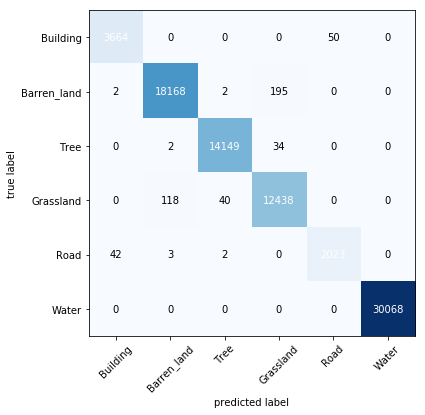

In [25]:
#label converter
# [1,0,0,0,0,0]=building
# [0,1,0,0,0]=barren_land
# [0,0,1,0,0,0]=tree
# [0,0,0,1,0,0]=grassland
# [0,0,0,0,1,0]=road
# [0,0,0,0,0,1]=water


##Building confusion matrix

y_pred=model.predict_classes(test_data_stn)
y_true=np.argmax(test_label.values, axis=1)
cm=confusion_matrix(y_target=y_true, y_predicted=y_pred)

plot_confusion_matrix(cm,class_names=["Building","Barren_land","Tree","Grassland","Road","Water"],figsize=(6,6) )
plt.show()

## Precision and Recall calculation for multiclass classification

In [26]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)


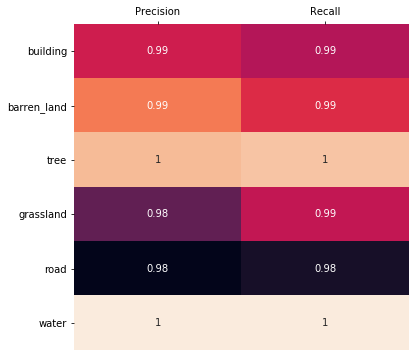

In [27]:

dic={}
precision_=[]
recall_=[]
precision_macro_average_=[]
for label in range(6):
    precision_.append(precision(label, cm))
    recall_.append(recall(label, cm))
    
dic["Precision"]= precision_
dic["Recall"]= recall_

plt.figure(figsize=(6,6))
ax=sns.heatmap(pd.DataFrame(dic, index=["building","barren_land","tree","grassland","road","water"]),annot=True,cbar=False)
plt.yticks(rotation=0)
ax.xaxis.tick_top() # x axis on top

plt.show()